**Preface:** Colab disclaimers

--Colab's free version works on a *dynamic usage limit*, which is not fixed and size is not documented anywhere—overall usage limits and timeout periods, maximum VM lifetime, GPU types available, and other factors vary over time. Colab does not publish these limits, in part because they can (and sometimes do) vary quickly. They also allegedly measure compute against demand, so if you use during peak times it uses up your credits faster. In addition, if you’re using new Google accounts, Colab doesn’t let you use it for as long. The account needs to be older to get more usage time.

--Google Colab notebooks have an idle timeout of 90 minutes and an absolute timeout of 12 hours. This means if a user does not interact with their Google Colab notebook for more than 90 minutes, their instance is automatically terminated. Also, the maximum lifetime of a Colab instance is 12 hours.

O ne method to avoid the 90-minute termination is to execute the following code in the console (Inspect Element):

function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

--Colab Pro: $10.00/month, gives 100 compute units. You are given a T4 GPU by default—the same as free tier, but a T4 GPU consumes 1.96 compute units per hour. If Colab Pro, you can choose "Premium GPU" from a drop down (e.g. a A100-SXM4-40GB is 15 compute units per hour)



# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import json

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

!pip install torchinfo
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.utils as vutils
from torch.nn.utils.parametrizations import spectral_norm

import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install deeplake
import deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.9/510.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5

In [ ]:
seed = 3407
# "torch.manual seed(3407) is all you need" (Picard 2021)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # includes CUDA

In [ ]:
print('CUDA version:', torch.version.cuda)
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA version: 11.8
PyTorch version: 2.0.1+cu118


In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 128
EPOCHS = 20

# why mini-batch sizes are typically powers of 2:
# https://stackoverflow.com/questions/44483233/is-using-batch-size-as-powers-of-2-faster-on-tensorflow

#  large-batch methods tend to converge to sharp minimizers of the training function. These minimizers are characterized by large positive eigenvalues in
# ∇^2𝑓(𝑥) and tend to generalize less well. In contrast, small-batch methods converge to flat minimizers characterized by
# small positive eigenvalues of ∇^2𝑓(𝑥)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
ds = deeplake.load('hub://activeloop/wiki-art')

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



/

hub://activeloop/wiki-art loaded successfully.



In [ ]:
class_names = np.unique(ds.labels.data()['text'])
n_class = len(class_names)

## Dataloader

In [ ]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(IMG_SIZE),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalizes images to [-1, 1]. more compatible with the tanh in the generator
    # so that the real and fake images have a similar distribution

    # archived:
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # summary statistics calculated from ImageNet, so they are standard practice.
    # you can calculate the new mean and std on your training data, but otherwise using the Imagenet pretrained
    # model with its own mean and std is recommended.

    # ^ potential problem:
    # https://discuss.pytorch.org/t/gan-training-fails-for-different-image-normalization-constants/10574/3
    # besides, ImageNet stats would be better for real life natural images, not paintings probably
])

In [ ]:
## for reverting normalization for visualization purposes
# invTrans = transforms.Normalize(
#                 mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
#                 std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
invTrans = transforms.Normalize(
                mean=[-1, -1, -1],
                std=[2, 2, 2])
# identical to "image * 0.5 + 0.5"

## Dataset

In [ ]:
class PaintingDataset(Dataset):
    '''
    Creates a PyTorch Dataset for the WikiArt painting data which is indexable and pre-applies specified image transformations.
    '''
    def __init__(self, ds, transform = None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)
        # When loading data sequentially, or when randomly loading samples from a tensor that fits
        # into the cache (such as class_labels) it is recommended to set fetch_chunks = True.
        # This increases the data loading speed by avoiding separate requests for each individual sample.
        # This is not recommended when randomly loading large tensors, because the data is deleted from the
        # cache before adjacent samples from a chunk are used.

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

In [ ]:
dataset = PaintingDataset(ds, transform = tform)

## Dataloader

In [ ]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 0, shuffle = True, pin_memory=True)
# remark on pin_memory:
# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU,
# you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.

####  archived: Gaussian Noise Function
(originally planned to inject into discriminator. no longer used because in its current form, detaching images to apply *random_noise()* removes them from the computational graph and the discriminator is left with no gradients. Perhaps one solution is to handle the random noise as a nn.parameter and apply it inside the discriminator class definition)

In [ ]:
# from skimage.util import random_noise

# def gaussian_noise(img):
#   gauss_img = torch.tensor(random_noise(img.detach().cpu(), mode='gaussian', mean=0, var=0.05, clip=True))
#   gauss_img = gauss_img.to(device).float()
#   return gauss_img

Text(0.5, 1.0, 'Image w/ Gaussian Noise')

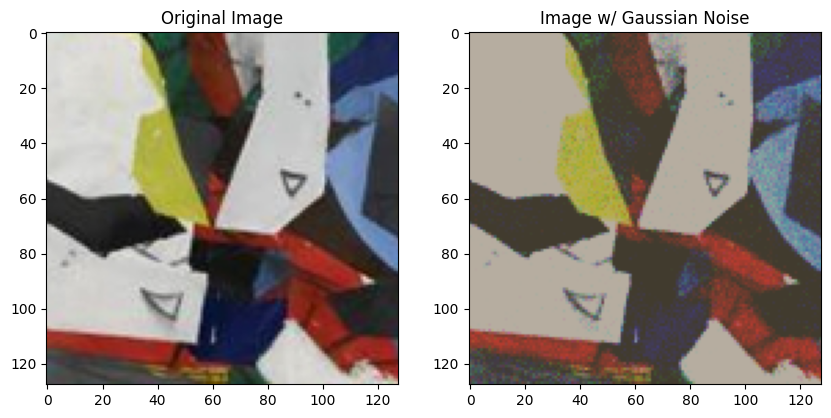

In [ ]:
# noise_img = gaussian_noise(dataset[2023]['images'])

# fig, ax = plt.subplots(1, 2, figsize=(10, 8))
# ax[0].imshow(np.transpose(invTrans(dataset[2023]['images']), (1,2,0)))
# ax[0].set_title("Original Image")
# ax[1].imshow(np.transpose(invTrans(noise_img), (1,2,0)))
# ax[1].set_title("Image w/ Gaussian Noise")

## Visualization

<ipython-input-50-ea39f1c89677>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,i+1)


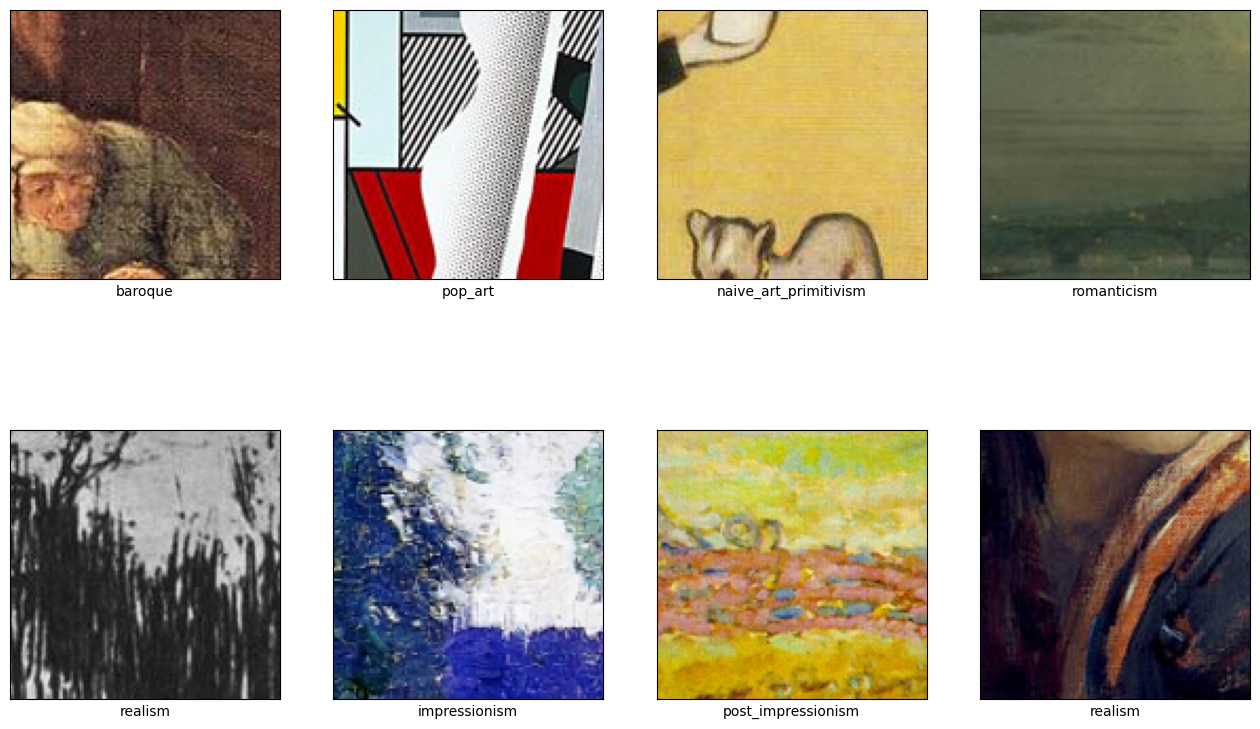

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Training Images')

images, labels = next(iter(dataloader)).values()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = invTrans(images[i]) # reverts image normalizations for display purposes
    image = np.transpose(image.cpu(), (1,2,0))
    plt.imshow(image)
    plt.xlabel(class_names[labels[i]])
plt.show()

# Model

In [ ]:
# Remarks:

# Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model,
# and it may shrink your input shape. Conversely, Conv2DTranspose is used for creating features, for example,
# in the decoder part of an autoencoder model for constructing an image. It makes the input shape larger.

# In GANs, the recommendation is to not use pooling or fully-connected layers

## Generator

In [ ]:
class Generator(nn.Module):

    # input: 64 (batch size) x 128 (noise vector dim) x 1 x 1

    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(128, 1024, kernel_size=6, stride=1, padding=1, bias=False) # 128 is just a hyperparameter for noise vector
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(1024)
        self.conv3 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False)

        # generally recommended to set bias = False because BatchNorm layer will re-centre the data anyway,
        # rendering the bias a useless trainable parameter.
        # However, since we have a non-linear activation like ReLU in, this statement may not apply

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()
        # ReLU should only be used within hidden layers. for generator output layer we use tanh

    # output: [64 (batch_size), 3 (# of channels), 128 (image_size), 128 (image_size)] (i.e. a properly sized image)

    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.bn5(self.relu(self.conv5(x)))
        x = self.bn6(self.relu(self.conv6(x)))
        x = self.tanh(self.conv7(x))
        return x

        # We use relu before BN = design choice. BN needs to come last after relu to properly do its job of normalizing layer inputs

In [ ]:
summary(Generator(), (64, 128, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 128, 128]         --
├─ConvTranspose2d: 1-1                   [64, 1024, 4, 4]          4,718,592
├─ReLU: 1-2                              [64, 1024, 4, 4]          --
├─BatchNorm2d: 1-3                       [64, 1024, 4, 4]          2,048
├─ConvTranspose2d: 1-4                   [64, 1024, 8, 8]          16,777,216
├─ReLU: 1-5                              [64, 1024, 8, 8]          --
├─BatchNorm2d: 1-6                       [64, 1024, 8, 8]          2,048
├─ConvTranspose2d: 1-7                   [64, 512, 16, 16]         8,388,608
├─ReLU: 1-8                              [64, 512, 16, 16]         --
├─BatchNorm2d: 1-9                       [64, 512, 16, 16]         1,024
├─ConvTranspose2d: 1-10                  [64, 256, 32, 32]         2,097,152
├─ReLU: 1-11                             [64, 256, 32, 32]         --
├─BatchNorm2d: 1-12                      [64, 2

## Discriminator

In [ ]:
class Discriminator(nn.Module):

     # input: 64 (batch size) x 3 (channels) x 128 x 128 (image size)

    def __init__(self):
        super().__init__()
        self.conv1 = spectral_norm(nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2, bias=False))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = spectral_norm(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False))
        self.bn6 = nn.BatchNorm2d(512)
        # Spectral normalization is a GAN stability technique which prevents vanishing / exploding gradients by controlling the Lipschitz constant of the
        # discriminator (specifically. normalizing the spectral norm of the weight matrix)
        # This does not affect batch normalization AFAIK. SN standardizes the weights of the layer, while BN standardizes activations.

        self.relu = nn.LeakyReLU(0.2, inplace=True)
        # LeakyRELU is popular in tasks where we may suffer from sparse gradients,
        # for example, training GANs

        self.discriminate = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(512*4*4, 256),
            # nn.Linear(256, 1),
            # nn.Sigmoid())
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid())

        self.classify = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(512*4*4, 1024),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Linear(1024, 512),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Linear(512, n_class))
            # # no softmax, will apply later
            nn.Conv2d(512, n_class, kernel_size=4, stride=1, padding=0, bias=False))

    def forward(self, x):
        # x = self.bn1(self.relu(self.conv1(gaussian_noise(x))))
        # x = self.bn2(self.relu(self.conv2(gaussian_noise(x))))
        # x = self.bn3(self.relu(self.conv3(gaussian_noise(x))))
        # x = self.bn4(self.relu(self.conv4(gaussian_noise(x))))
        # x = self.bn5(self.relu(self.conv5(gaussian_noise(x))))
        # x = self.bn6(self.relu(self.conv6(gaussian_noise(x))))
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.bn5(self.relu(self.conv5(x)))
        x = self.bn6(self.relu(self.conv6(x)))

        disc_p = self.discriminate(x)
        style_p = self.classify(x)
        return disc_p, style_p

        # note we use relu before BN, design choice. BN needs to come last after relu and pooling to properly do its job of normalizing layer inputs

In [ ]:
summary(Discriminator(), (64, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1, 1, 1]             --
├─ParametrizedConv2d: 1-1                [64, 32, 129, 129]        --
│    └─ModuleDict: 2-1                   --                        --
│    │    └─ParametrizationList: 3-1     [32, 3, 4, 4]             1,536
├─LeakyReLU: 1-2                         [64, 32, 129, 129]        --
├─BatchNorm2d: 1-3                       [64, 32, 129, 129]        64
├─ParametrizedConv2d: 1-4                [64, 64, 64, 64]          --
│    └─ModuleDict: 2-2                   --                        --
│    │    └─ParametrizationList: 3-2     [64, 32, 4, 4]            32,768
├─LeakyReLU: 1-5                         [64, 64, 64, 64]          --
├─BatchNorm2d: 1-6                       [64, 64, 64, 64]          128
├─ParametrizedConv2d: 1-7                [64, 128, 32, 32]         --
│    └─ModuleDict: 2-3                   --                        --
│    │ 

In [ ]:
def weight_init(model_layer):
    '''
    Custom weight initialization function to be applied to each model layer of a given model.
    '''
    layer_name = model_layer.__class__.__name__
    if layer_name.find('Conv') != -1:
        # originally used Xavier normal initialization to convolutional layers (varaince of activations same across every layer to prevent
        # gradient from exploding or vanishing)
        # nn.init.xavier_normal_(model_layer.weight.data)
        nn.init.normal_(model_layer.weight.data, 0, 0.02)
    elif layer_name.find('BatchNorm') != -1:
        # cannot use Xavier for BatchNorm layers because it's 1D not 2D, so cannot compute fan in/fan out values
        nn.init.normal_(model_layer.weight.data, 1, 0.02)
        nn.init.constant_(model_layer.bias.data, 0)

# Initialization and setup

In [ ]:
# instantiate models
gen = Generator().to(device)
disc = Discriminator().to(device)

In [ ]:
# weight initialization
gen.apply(weight_init);
disc.apply(weight_init);

In [ ]:
loss = nn.BCELoss() # BCELoss does not have label smoothing, will implement manually
style_loss = nn.CrossEntropyLoss(label_smoothing=0.2) # to help discriminator be less confident

In [ ]:
# For visualization of training process
# 128 is just a hyperparameter

# Generate fixed noise (only run the first time)
# fixed_noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
# torch.save(fixed_noise, f'/content/drive/MyDrive/Pic 16B/CAN/fixed_noise.pt')

# Load in the fixed noise (if on CPU, use second)
# fixed_noise = torch.load(f'/content/drive/MyDrive/Pic 16B/CAN/fixed_noise.pt').to(device)
fixed_noise = torch.load(f'/content/drive/MyDrive/Pic 16B/CAN/fixed_noise.pt', map_location=torch.device('cpu')).to(device)
print("Fixed noise loaded")

Fixed noise loaded


In [ ]:
# Real vs. fake labels training (as floats)
real_label = 1.
fake_label = 0.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

In [ ]:
# Setup optimizers for both G and D
optimizer_G = optim.AdamW(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.AdamW(disc.parameters(), lr=0.00002, betas=(0.5, 0.999))

# Learning rate exponential decay
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.794)
# ensures we decay to 1% of LR after 20 epochs (before_lr * gamma^(num steps) = after_lr)

# side remark: For Adam, every parameter in the network has its own specific learning rate
# However, this is still useful. Each learning rate is computed using lambda (the initial learning rate) as an upper limit
# This means that every single learning rate can vary from 0 (no update) to lambda (maximum update)

# define LR warmup
num_warmup_epochs = 7

# archived: steep warmup function——1/1000, 1/100, etc.
# def warmup(current_step: int):
#     return 1 / (10 ** (float(num_warmup_epochs - current_step)))

def warmup(current_step: int):
  if current_step < 3:
    return (current_step+2) / 4 # current_step starts at 0
  else:
    return 1
# ^ this setup yields 0.5*LR, 0.75*LR, LR...LR before decay begins

warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=warmup)
scheduler = optim.lr_scheduler.SequentialLR(optimizer_D, [warmup_scheduler, scheduler_D], [num_warmup_epochs-1])

# Remark: "In general, if you're using Adam/AdamW include a warmup and some annealing, either linear or cosine.
# If you're using radam/ranger/variants, you can skip the warmup."

# One helpful unconfirmed method is to use SGD for discriminator and Adam for generator. Tried but did not do much

# Beta controls moving average. commonly 𝛽 = 0.9 = averaging over the last 10 iterations’ gradients, older gradients are discarded.
# larger beta means taking into account more gradients
# ^ beta1 = exponential decay for momentum, but there's also beta2 = exponential decay for velocity (default 0.999)

In [ ]:
# for testing learning rate only. if this cell is run, re-run the cell above to reset, because this cell actually steps the scheduler
for i in range(25):
  print(i, scheduler.optimizer.param_groups[0]['lr'])
  scheduler.step()

0 1e-05
1 1.5000000000000002e-05
2 2e-05
3 2e-05
4 2e-05
5 2e-05
6 2e-05
7 1.588e-05
8 1.2608720000000001e-05
9 1.0011323680000001e-05
10 7.948991001920002e-06
11 6.311498855524481e-06
12 5.011330091286438e-06
13 3.9789960924814325e-06
14 3.1593228974302575e-06
15 2.5085023805596245e-06
16 1.991750890164342e-06
17 1.5814502067904876e-06
18 1.2556714641916473e-06
19 9.97003142568168e-07
20 7.916204951991255e-07
21 6.285466731881057e-07
22 4.990660585113559e-07
23 3.962584504580166e-07
24 3.1462920966366524e-07


# Training

### temporarily training on a subset

In [ ]:
sub_idx = list(range(0, len(dataset), 12)) # subset contains every 12th painting
# currently, ds deeplake dataset backend has some problems such as with images 75879, 75880, so don't revert to 10 or any number
# which might train on these
train_subset = Subset(dataset, sub_idx)
train_subset_loader = DataLoader(train_subset, batch_size = BATCH_SIZE, num_workers = 8, shuffle = True, pin_memory=True)
# num workers notes:
# Every worker process is always responsible for loading a whole batch
# num_workers = 0 means that it’s the main process that will do the data loading when needed
# Having more workers will increase the memory usage and that’s the most serious overhead
# Setting workers to number of cores is a good rule of thumb, but you could technically give more

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# comment out variable initializations if loading (see below cell to load)
img_list = []
G_losses = []
D_losses = []
entropies = []
iters = 0

# for timing
import time
durations = []

print("Beginning model training:")

for epoch in range(0, EPOCHS):
  print(f"Epoch {epoch+1}, Discriminator learning rate: {scheduler.optimizer.param_groups[0]['lr']}")
  data_iter = iter(train_subset_loader)
  for i in range(len(train_subset_loader)): # num of batches in epoch
    start = time.time()

    img, style_label = next(data_iter).values()
    # Part A: Train discriminator
    # i) Real painting data
    disc.zero_grad()

    style_label = style_label.to(device)
    img_cpu = img.to(device)
    b_size = img_cpu.shape[0] # to deal with case of last batch when not equal to BATCH_SIZE
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # slight label smoothing from hard labels 1 to [0.7, 1.2)
    label = label - 0.3 + torch.rand(b_size, device=device)*0.5

    # Forward pass real batch through discriminator
    output, output_style = disc(img_cpu)
    # Calculate loss on all-real batch
    errD_real = loss(output.squeeze(), label)
    style_label = style_label.to(torch.long) # equivalent to torch.int64 to appease categorical CE loss function input requirements
    errD_real = errD_real + style_loss(output_style.squeeze(), style_label.squeeze())
    # Calculate gradients in backward pass
    errD_real.backward(retain_graph=True)
    D_x = output.mean().item()

    # ii) Generated batch
    noise = torch.randn(b_size, 128, 1, 1, device=device)

    fake = gen(noise)
    label.fill_(fake_label)

    # Forward pass
    output, output_style = disc(fake)
    # ---------------

    # Calculate loss on fake batch
    errD_fake = loss(output.squeeze(), label)
    # Calculate the gradients for this batch
    errD_fake.backward(retain_graph=True)
    D_G_z1 = output.mean().item()

    # Compute discriminator total loss
    errD = errD_real + errD_fake

    # Clip the discriminator gradient norms (hyperparameter) between .backward and step().
    # current variant: aggressive clipping
    nn.utils.clip_grad_norm_(disc.parameters(), max_norm=10.0)

    # to-do: apparently this clips gradients after backprop, not during
    # https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
    # instead, you can register a backward hook:
    # for p in model.parameters():
    #   p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    # This hook is called each time after a gradient has been computed, i.e. there's no need for manually clipping once the hook has been registered

    # Update discriminator
    optimizer_D.step()

    # Investigate discriminator gradient norms
    if i % 10 == 0:
      grads = [
        param.grad.detach().flatten()
        for param in disc.parameters()
        if param.grad is not None
        ]
      norm = torch.cat(grads).norm()
      print(f"Discriminant gradient norm: {norm:.4f}")

    # Part B: Train generator
    gen.zero_grad()

    label.fill_(real_label)  # fake labels are real for generator cost, flipped because the generator's aim
    # is to maximize the discriminator's real/fake loss

    # After having updated the discriminator, we perform another forward pass of fake batch to compute new loss
    output, output_style = disc(fake)

    # Uniform cross entropy
    logsoftmax = nn.LogSoftmax(dim=1)
    unif = torch.full((b_size, n_class), 1/n_class).to(device)
    # Calculate G's loss on new D output
    errG = loss(output.squeeze(), label)
    errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
    # style ambiguity loss——cross-entropy between the class posterior and a uniform distribution
    # breakdown: we sum across each row (an image), and there are 27 columns (styles).
    # This means each image (row) has predicted probabilities for each style (27), which are determined by 1/27 * logsoftmax(output_style)
    # in accordance with the formula, we find the mean of the row sums (+ negative sign)

    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()

    # Clip the generator gradient norms (hyperparameter) between .backward and step()
    # current variant: aggressive clipping
    nn.utils.clip_grad_norm_(gen.parameters(), max_norm=10.0)

    # Update G
    optimizer_G.step()

    # Investigate generator gradient norms
    if i % 10 == 0:
      grads = [
        param.grad.detach().flatten()
        for param in gen.parameters()
        if param.grad is not None
        ]
      norm = torch.cat(grads).norm()
      print(f"Generator gradient norm: {norm:.4f}")

    # Not used to update the model, simply for training output
    # Written with an additional softmax to restrict the bounds to 0 to 1 for interpretability
    style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
    # ^ Log_softmax heavily penalizes mistakes in likelihood space (more so than vanilla softmax)
    style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())

    # ----------
    # note: another method to train is to pass real and fake, get all generator outputs and discriminator outputs on both, then
    # in an organized manner, update disc w/ real batch real/fake loss + real batch style loss + fake batch real/fake loss
    # reset_grad (d_optimizer.zero_grad(), g_optimizer.zero_grad())), then D_loss.backward(retain_graph=True), optimizer_D.step(), then train G w/
    # fake batch real/fake loss (w/ opposite labels ofc) + uniform cross entropy, reset_grad, backward, and step

    stop = time.time()
    durations.append(stop-start)

    if i % 10 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f'
              % (epoch+1, EPOCHS, i, len(train_subset_loader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))

    G_losses.append(errG.item())
    D_losses.append(errD.item())
    entropies.append(style_entropy.item())

    # Append generated images using model after each 75 batches or at end of training to visualize training process
    if (iters % 75 == 0) or ((epoch == EPOCHS-1) and (i == len(train_subset_loader)-1)):
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, normalize=True))

    iters += 1

  # learning rate scheduler for discriminator. step every epoch
  scheduler.step()

  print(f"Average execution time per batch of {BATCH_SIZE} in epoch {epoch+1}: {np.array(durations).mean()} seconds")
  # remark: of course, the last batch of every epoch only has size b_size but given 100+ batches it should not matter too much

  # save models and progress every epoch
  torch.save({
      "model_state_dict": gen.state_dict(),
      "optimizer_state_dict": optimizer_G.state_dict()},
      f'/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_{epoch+1}.pt')

  torch.save({
      "model_state_dict": disc.state_dict(),
      "optimizer_state_dict": optimizer_D.state_dict(),
      "scheduler_state_dict": scheduler_D.state_dict()}, # scheduler
      f'/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_{epoch+1}.pt')

  torch.save(img_list, f'/content/drive/MyDrive/Pic 16B/CAN/img_list.pt')

  with open(f'/content/drive/MyDrive/Pic 16B/CAN/G_losses.json', 'w') as f2:
    json.dump(G_losses, f2)
  with open(f'/content/drive/MyDrive/Pic 16B/CAN/D_losses.json', 'w') as f3:
    json.dump(D_losses, f3)
  with open(f'/content/drive/MyDrive/Pic 16B/CAN/entropies.json', 'w') as f4:
    json.dump(entropies, f4)

  print(f"Epoch {epoch+1} finished, model + data saved")

Beginning model training:
Epoch 1, Discriminator learning rate: 1e-05
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][0/107]	Loss_D: 6.7219	Loss_G: 6.3035	D(x): 0.4671	D(G(z)): 0.4599 / 0.3403	 Entropy: 0.6430
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][10/107]	Loss_D: 7.9403	Loss_G: 5.0734	D(x): 0.5452	D(G(z)): 0.8437 / 0.7467	 Entropy: 0.6647
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][20/107]	Loss_D: 7.9270	Loss_G: 5.0794	D(x): 0.5421	D(G(z)): 0.8618 / 0.6992	 Entropy: 0.6701
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][30/107]	Loss_D: 8.5092	Loss_G: 4.9363	D(x): 0.5469	D(G(z)): 0.9208 / 0.7959	 Entropy: 0.6591
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][40/107]	Loss_D: 8.0628	Loss_G: 5.0985	D(x): 0.5912	D(G(z)): 0.8897 / 0.7190	 Entropy: 0.6643
Discriminant gradient norm: 10.0000
Generator gradient norm: 10.0000
[1/20][50/107]	Lo

In [ ]:
# LOADING
n_class = 27

gen = Generator().to(device)
disc = Discriminator().to(device)

# Setup optimizers for both G and D
optimizer_G = optim.AdamW(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.AdamW(disc.parameters(), lr=0.00002, betas=(0.5, 0.999))

# exponential decay + learning rate
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.794)

# For the below lines, use the 2nd versions if running on CPU

# gen.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_4.pt')["model_state_dict"])
# disc.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt')["model_state_dict"])

gen.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_4.pt',
                               map_location=torch.device('cpu'))["model_state_dict"])
disc.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt',
                                map_location=torch.device('cpu'))["model_state_dict"])
print("Generator and discriminator models loaded")

# optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_4.pt')["optimizer_state_dict"])
# optimizer_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt')["optimizer_state_dict"])

optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_4.pt',
                                       map_location=torch.device('cpu'))["optimizer_state_dict"])
optimizer_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt',
                                       map_location=torch.device('cpu'))["optimizer_state_dict"])
print("Optimizers loaded from checkpoint")

# scheduler_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt')["scheduler_state_dict"])
scheduler_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_4.pt',
                               map_location=torch.device('cpu'))["scheduler_state_dict"])

# define warmup
num_warmup_epochs = 7
def warmup(current_step: int):
  if current_step < 3:
    return (current_step+2) / 4 # current_step starts at 0
  else:
    return 1

warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=warmup)
scheduler = optim.lr_scheduler.SequentialLR(optimizer_D, [warmup_scheduler, scheduler_D], [num_warmup_epochs-1])
print("Discriminator LR scheduler loaded from checkpoint")

img_list = torch.load(f'/content/drive/MyDrive/Pic 16B/CAN/img_list.pt')
print("Images loaded")
with open(f'/content/drive/MyDrive/Pic 16B/CAN/G_losses.json', 'r') as f2:
  G_losses = json.load(f2)
with open(f'/content/drive/MyDrive/Pic 16B/CAN/D_losses.json', 'r') as f3:
  D_losses = json.load(f3)
print("Losses loaded")
with open(f'/content/drive/MyDrive/Pic 16B/CAN/entropies.json', 'r') as f4:
  entropies = json.load(f4)
print("Entropies loaded")


# iters = num of epochs * num batches per epoch
iters = 4*len(train_subset_loader)

Generator and discriminator models loaded
Optimizers loaded from checkpoint
Discriminator LR scheduler loaded from checkpoint
Images loaded
Losses loaded
Entropies loaded


### checking generated image

torch.Size([3, 128, 128])


<ipython-input-11-89688059cbdc>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(invTrans(fake[0]).cpu().detach().T)


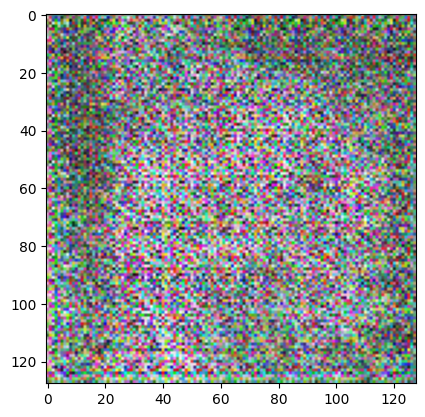

In [ ]:
disc.zero_grad()
noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
fake = gen(noise)
print(fake[0].shape)
plt.imshow(invTrans(fake[0]).cpu().detach().T)

## Training Visualizations

### Training Loss

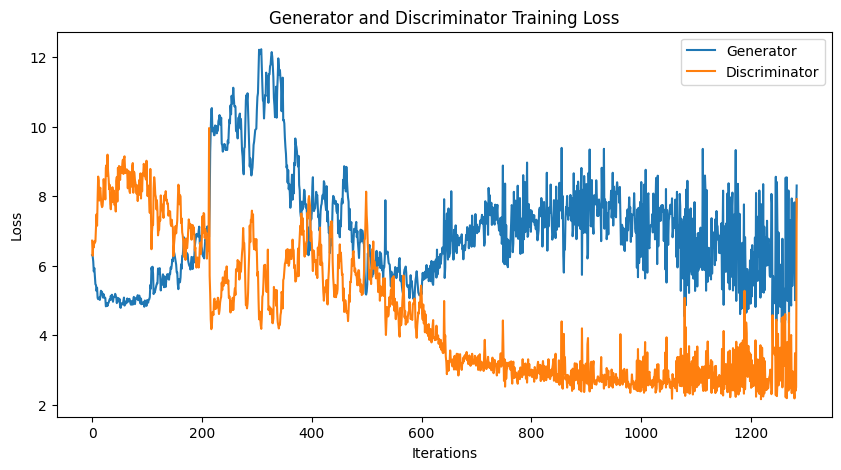

In [ ]:
# latest attempt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

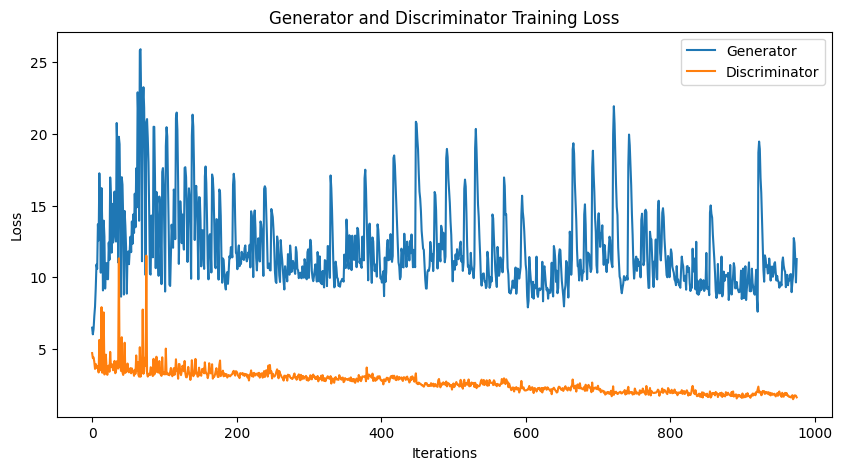

In [ ]:
# another previous variant
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

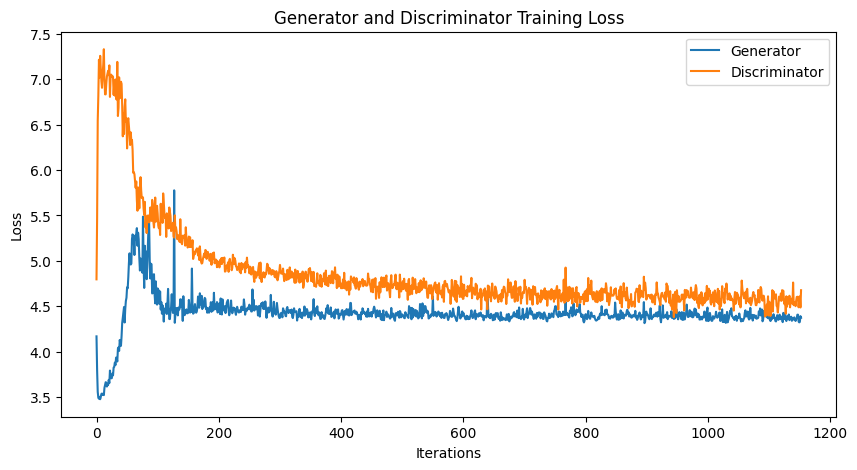

In [ ]:
# another previous variant
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# one thing that should happen often enough (depending on your data and initialisation) is that both the discriminator and
# generator losses converge to some numbers and stabilize for the most part

### Discriminator Entropy

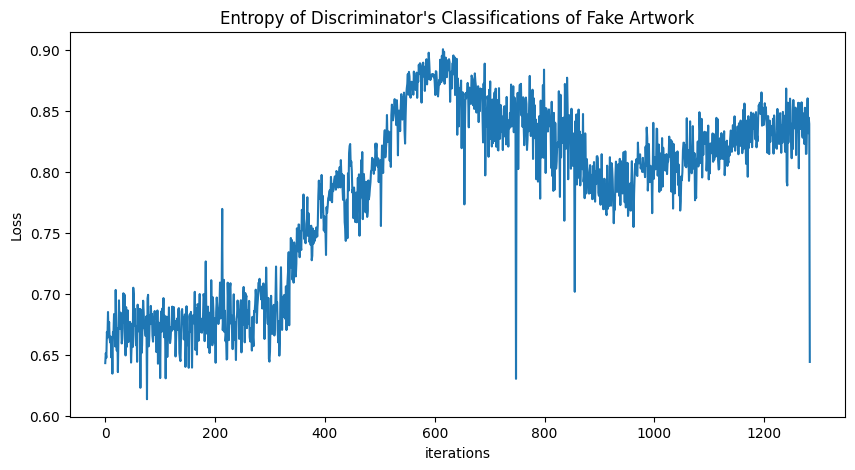

In [ ]:
# latest attempt
plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

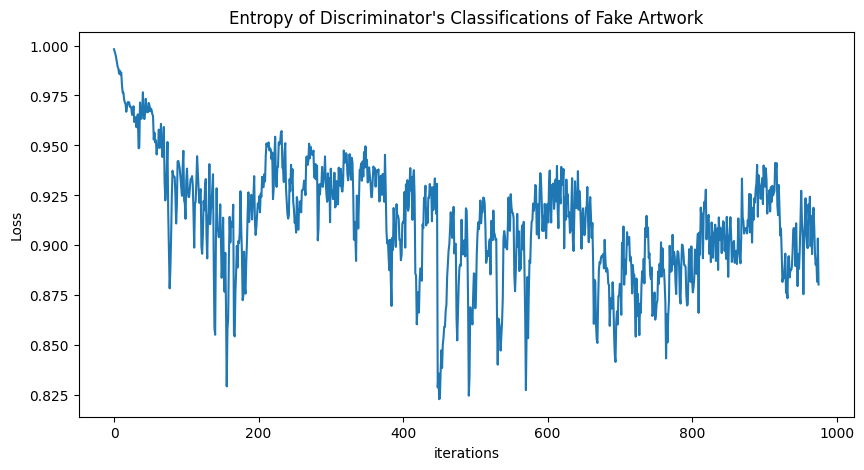

In [ ]:
# another previous variant——when linear layers used in discriminator
plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

### Generator Images Animation

In [ ]:
# latest attempt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(invTrans(i),(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# another previous variant
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(invTrans(i),(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# another previous variant
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(invTrans(i),(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Real vs. Fake Paintings

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


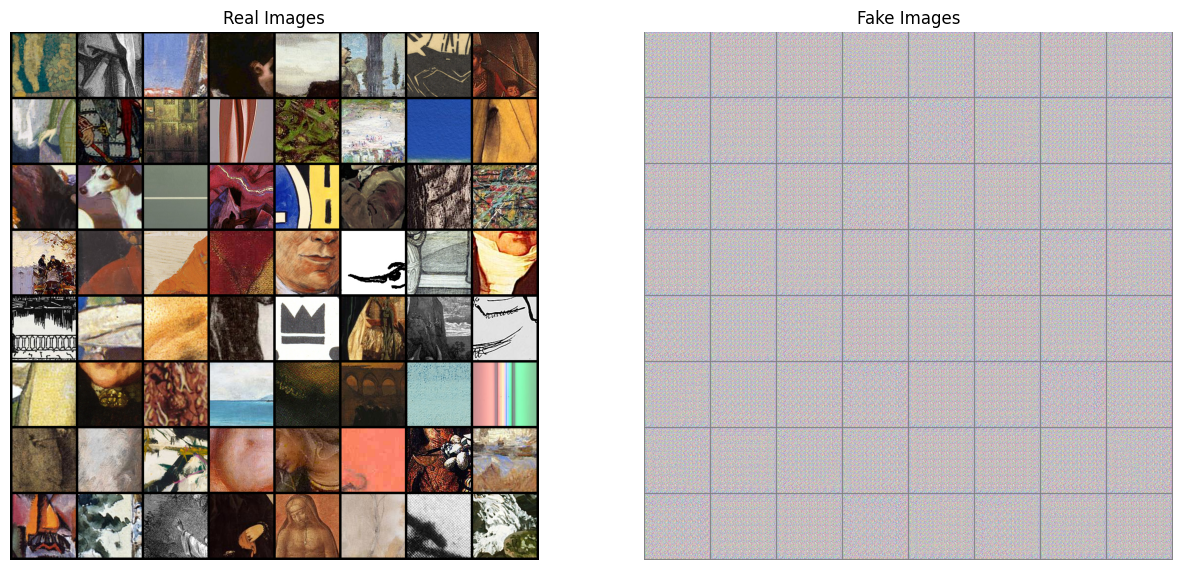

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_subset_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(invTrans(real_batch['images']).to(device)[:BATCH_SIZE], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last saved img_list
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(invTrans(img_list[-1]),(1,2,0)))
plt.show()

# Download generated images

In [ ]:
import os
from tqdm import tqdm

img_path = "/content/drive/MyDrive/Pic 16B/CAN/CAN_images"

if not os.path.exists(img_path):
    os.makedirs(img_path)
# makedirs() creates all the intermediate directories if they don't exist (just like mkdir -p in bash).
# in contrast, mkdir() can create a single sub-directory, and will throw an exception if intermediate directories
# that don't exist are specified

# generate and save one image at a time. this was actually done on CPU to avoid running into GPU RAM problems
for i in tqdm(range(10000)):
    noise = torch.randn(1, 128, 1, 1,)
    fake = invTrans(gen(noise)).squeeze(0).detach().numpy().T

    img = Image.fromarray((fake * 255).astype(np.uint8))
    img.save(f"{img_path}/gen_image_{i}.png")